In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchsummary import summary
from PIL import Image
import torch.optim as optim
from tqdm import tqdm
import os
import shutil
import random

In [ ]:
### this script is commented because it is not used anymore
### all the data that i used in this part of code will not be sent because it is too big
### this part of code should generate the folder data which will be given


# # Définir les chemins
# source_dir = "all_data/docs-sm"  # Dossier contenant toutes les images
# train_dir = "data/train"
# val_dir = "data/val"

# split_ratio = 0.8  # 80% train, 20% validation

# # Créer les dossiers train/val s'ils n'existent pas
# for split in ["train", "val"]:
#     os.makedirs(os.path.join("data", split, "classe0"), exist_ok=True)
#     os.makedirs(os.path.join("data", split, "classe1"), exist_ok=True)
#     os.makedirs(os.path.join("data", split, "classe2"), exist_ok=True)

# # Séparer les images pour chaque classe
# for classe in [("letter",'classe0'), ("handwritten",'classe1'),('handwritten_and_typed','classe2')]:
#     class_path = os.path.join(source_dir, classe[0])
#     print(class_path)
#     images = os.listdir(class_path)
#     random.shuffle(images)  # Mélanger les images

#     split_idx = int(len(images) * split_ratio)  # Index de séparation
#     train_images = images[:split_idx]  # 80% des images
#     val_images = images[split_idx:]  # 20% des images

#     # Copier les images dans les nouveaux dossiers
#     for img in train_images:
        
#         shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, classe[1], img))

#     for img in val_images:
#         shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, classe[1], img))

# print("Données organisées avec succès ! 🚀")


all_data/docs-sm\letter
all_data/docs-sm\handwritten
all_data/docs-sm\handwritten_and_typed
Données organisées avec succès ! 🚀


In [5]:
# Define data transformations (resize, normalize, augment if needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Required for ResNet/VGG input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load dataset (Assume your medical images are in 'data/train' and 'data/val')
train_dataset = datasets.ImageFolder(root="data/train", transform=transform)
val_dataset = datasets.ImageFolder(root="data/val", transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [3]:
# Load ResNet50 pretrained on ImageNet
model = models.resnet50(pretrained=True)
# Freeze all layers except the final classification layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

num_features = model.fc.in_features  # Get number of input features in the last FC layer

num_classes = 3  

model.fc = nn.Linear(num_features, num_classes) 
# Replace the last layer 2 classes insted of 1000 classes
summary(model, (3, 224, 224))  # La forme d'entrée attendue pour ResNet-50 est (3, 224, 224)

c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [9]:
num_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {num_params/10**6:.2f} M parameters ")

Total number of parameters: 23.51 M parameters 


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  
# Fine-tune only last layer. This is very essential to keep 
# the paramaters of the other layers unchanged.


In [7]:
def estimate_accuracy():
    model.eval()
    correct = 0
    total = 0
    c=0
    false_images=[]
    with torch.no_grad():  # No gradient calculation needed for evaluation
        for images, labels in val_loader:
            
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            false_images.append(images[predicted!=labels])
            


    accuracy = 100 * correct / total
    return accuracy

In [ ]:
num_epochs = 10 
accuracy = estimate_accuracy()
val_accuracy = [accuracy]  
print(f'Initial accuracy: {accuracy:.2f}%')

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()  
        optimizer.step()  

        running_loss += loss.item()
    
    accuracy = estimate_accuracy()
    max_accuracy = max(val_accuracy)

    if accuracy > max_accuracy:
        print(f'The model accuracy improved from {max_accuracy:.2f}% to {accuracy:.2f}%')
        # torch.save(model.state_dict(), 'best_weights.pth')  # Save best model
        # i commented saving the model to keep the model saved with accuracy 89:85
    val_accuracy.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, \
          Validation Accuracy: {accuracy:.2f}%")

# Load the best model weights
model.load_state_dict(torch.load('best_weights.pth'))


Initial accuracy: 19.54%


 10%|█         | 1/10 [03:07<28:07, 187.50s/it]

The model accuracy improved from 19.54% to 70.92%
Epoch [1/10], Train Loss: 0.9367,           Validation Accuracy: 70.92%


 20%|██        | 2/10 [06:17<25:10, 188.75s/it]

The model accuracy improved from 70.92% to 81.23%
Epoch [2/10], Train Loss: 0.6815,           Validation Accuracy: 81.23%


 30%|███       | 3/10 [09:24<21:57, 188.20s/it]

The model accuracy improved from 81.23% to 84.92%
Epoch [3/10], Train Loss: 0.6113,           Validation Accuracy: 84.92%


 40%|████      | 4/10 [12:42<19:11, 191.88s/it]

The model accuracy improved from 84.92% to 86.31%
Epoch [4/10], Train Loss: 0.5703,           Validation Accuracy: 86.31%


 50%|█████     | 5/10 [16:20<16:47, 201.53s/it]

Epoch [5/10], Train Loss: 0.5745,           Validation Accuracy: 85.23%


 60%|██████    | 6/10 [19:58<13:47, 206.88s/it]

Epoch [6/10], Train Loss: 0.5050,           Validation Accuracy: 82.00%


 70%|███████   | 7/10 [23:36<10:32, 210.77s/it]

Epoch [7/10], Train Loss: 0.4823,           Validation Accuracy: 76.77%


 80%|████████  | 8/10 [27:15<07:06, 213.12s/it]

The model accuracy improved from 86.31% to 86.62%
Epoch [8/10], Train Loss: 0.5216,           Validation Accuracy: 86.62%


 90%|█████████ | 9/10 [30:46<03:32, 212.76s/it]

The model accuracy improved from 86.62% to 87.69%
Epoch [9/10], Train Loss: 0.4572,           Validation Accuracy: 87.69%


100%|██████████| 10/10 [34:18<00:00, 205.84s/it]

The model accuracy improved from 87.69% to 89.85%
Epoch [10/10], Train Loss: 0.4386,           Validation Accuracy: 89.85%



C:\Users\marie\AppData\Local\Temp\ipykernel_11968\2768371345.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_weights.pth'))


<All keys matched successfully>

In [82]:
estimate_accuracy()

89.84615384615384

In [ ]:
from collections import Counter
def prediction_distribution(classe):
    initial_path='data/val/classe'+str(classe) # mixed : handwritten and typed
    n=len(os.listdir(initial_path))
    paths=[initial_path+'/'+os.listdir(initial_path)[i] for i in range(n)]
    labels=[]
    false_indices=[]
    for i in range(n):
        image=Image.open(paths[i])
        image_tensor=transform(image.convert('RGB'))
        labels.append(torch.argmax(model(image_tensor.unsqueeze(0))).numpy())
        if torch.argmax(model(image_tensor.unsqueeze(0))).numpy()==1:
            false_indices.append(i)
    labels=np.array(labels)
    label_counts = Counter(labels)
    classes = list(label_counts.keys())
    counts = list(label_counts.values())
    colors = ['lightblue', 'lightcoral', 'lightgreen']
    label_mapping = {0: 'Typed', 1: 'Handwritten', 2: 'Mixed'}
    class_labels = [label_mapping[c] for c in classes]
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=class_labels, autopct='%1.1f%%', colors=colors, startangle=140)
    plt.title(f'Distribution of {label_mapping[classe]} data')
    plt.show()

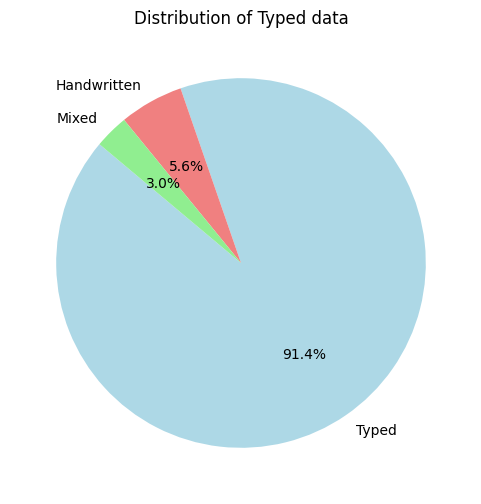

In [ ]:
#how the model predicts the typed data
prediction_distribution(0)

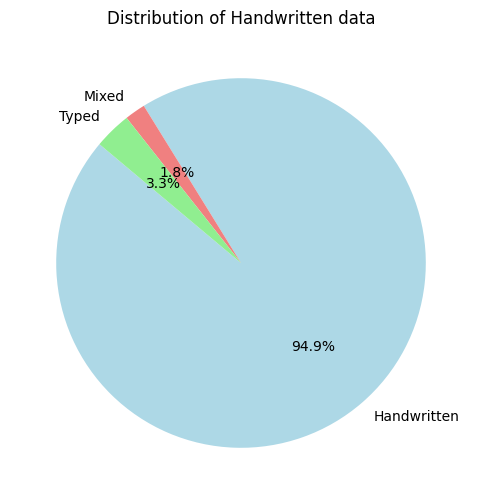

In [ ]:
#how the model predicts the handwritten data
prediction_distribution(1)

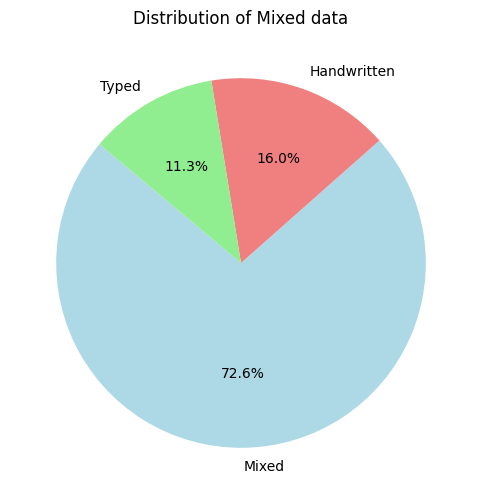

In [ ]:
#how the model predicts the mixed data
prediction_distribution(2)